In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [56]:
trades = pd.read_csv("/content/historical_data.csv")

sentiment = pd.read_csv("/content/fear_greed_index.csv")

In [57]:
trades = trades[[
    "Execution Price",
    "Size USD",
    "Side",
    "Fee",
    "Timestamp IST"
]]


In [58]:
trades["Timestamp IST"] = pd.to_datetime(
    trades["Timestamp IST"],
    format="%d-%m-%Y %H:%M"
)


In [59]:
trades["date"] = trades["Timestamp IST"].dt.date


In [60]:
trades["Side"] = trades["Side"].map({"BUY": 1, "SELL": -1})

# Pre-Processing

In [61]:
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date

In [62]:
sentiment = sentiment[[
    "date",
    "value",
    "classification"
]]

In [63]:
def simplify_sentiment(x):
    if x in ["Extreme Fear", "Fear"]:
        return "Fear"
    elif x in ["Greed", "Extreme Greed"]:
        return "Greed"
    else:
        return "Neutral"

sentiment["Sentiment"] = sentiment["classification"].apply(simplify_sentiment)

In [64]:
merged_data = pd.merge(
    trades,
    sentiment,
    on="date",
    how="left"
)

In [65]:
merged_data.dropna(subset=["Sentiment"], inplace=True)

In [66]:
print(merged_data.head())


   Execution Price  Size USD  Side       Fee       Timestamp IST        date  \
0           7.9769   7872.16     1  0.345404 2024-12-02 22:50:00  2024-12-02   
1           7.9800    127.68     1  0.005600 2024-12-02 22:50:00  2024-12-02   
2           7.9855   1150.63     1  0.050431 2024-12-02 22:50:00  2024-12-02   
3           7.9874   1142.04     1  0.050043 2024-12-02 22:50:00  2024-12-02   
4           7.9894     69.75     1  0.003055 2024-12-02 22:50:00  2024-12-02   

   value classification Sentiment  
0   80.0  Extreme Greed     Greed  
1   80.0  Extreme Greed     Greed  
2   80.0  Extreme Greed     Greed  
3   80.0  Extreme Greed     Greed  
4   80.0  Extreme Greed     Greed  


Market Sentiment

In [67]:
trade_count = merged_data.groupby("Sentiment").size().reset_index(name="Number of Trades")
print(trade_count)

  Sentiment  Number of Trades
0      Fear             83237
1     Greed             90295
2   Neutral             37686


In [68]:
avg_trade_size = (
    merged_data.groupby("Sentiment")["Size USD"]
    .mean()
    .reset_index(name="Average Trade Size (USD)")
)

print(avg_trade_size)

  Sentiment  Average Trade Size (USD)
0      Fear               7182.011019
1     Greed               4574.424490
2   Neutral               4782.732661


In [69]:
total_volume = (
    merged_data.groupby("Sentiment")["Size USD"]
    .sum()
    .reset_index(name="Total Volume (USD)")
)

print(total_volume)

  Sentiment  Total Volume (USD)
0      Fear        5.978091e+08
1     Greed        4.130477e+08
2   Neutral        1.802421e+08


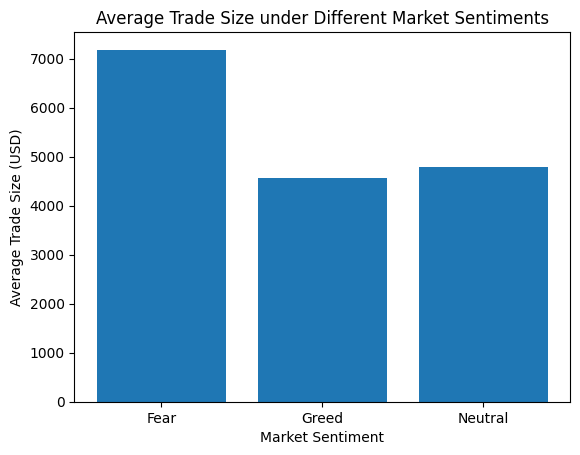

In [70]:
plt.figure()
plt.bar(
    avg_trade_size["Sentiment"],
    avg_trade_size["Average Trade Size (USD)"]
)
plt.xlabel("Market Sentiment")
plt.ylabel("Average Trade Size (USD)")
plt.title("Average Trade Size under Different Market Sentiments")
plt.show()

Classification Greed V/s Fear


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [42]:
classifer = merged_data.copy()

In [43]:
classifer = classifer[classifer["Sentiment"].isin(["Fear", "Greed"])]

In [44]:
classifer["Sentiment_Label"] = classifer["Sentiment"].map({
    "Fear": 0,
    "Greed": 1
})

classifer.dropna(subset=["Sentiment_Label", "Size USD", "Fee"], inplace=True)

In [45]:
X = classifer[["Size USD", "Fee"]]
y = classifer["Sentiment_Label"]

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)



In [47]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

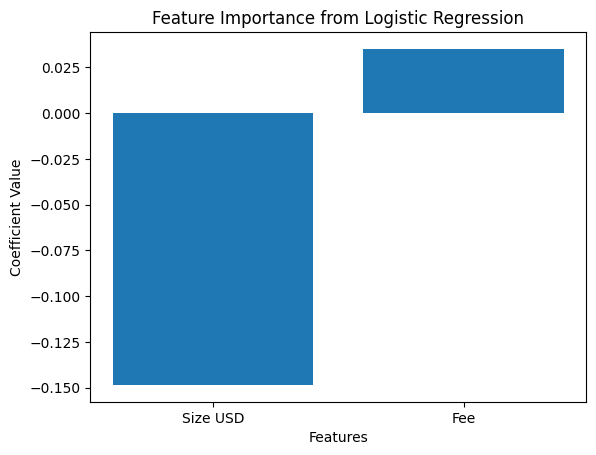

In [52]:
importance = model.coef_[0]
features = X.columns

plt.figure()
plt.bar(features, importance)
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.title("Feature Importance from Logistic Regression")
plt.show()


In [53]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.5224932769880907

Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.04      0.07     25101
           1       0.52      0.97      0.68     26959

    accuracy                           0.52     52060
   macro avg       0.55      0.51      0.38     52060
weighted avg       0.54      0.52      0.39     52060



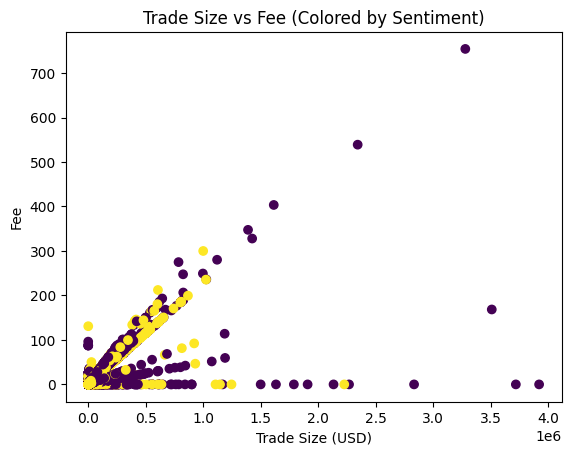

In [54]:
plt.figure()
plt.scatter(
    classifer["Size USD"],
    classifer["Fee"],
    c=classifer["Sentiment_Label"]
)
plt.xlabel("Trade Size (USD)")
plt.ylabel("Fee")
plt.title("Trade Size vs Fee (Colored by Sentiment)")
plt.show()